In [44]:
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SEED = 42
np.random.seed(SEED)

## Funções

In [61]:
def avaliar_modelo(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f'Acurácia: {accuracy}')
    print(f'Precisão: {precision}')
    print(f'Recall: {recall}')

    # Matriz de Confusão e Relatório de Classificação
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')

In [60]:
def perform_predictions(X_train, X_test, y_train, y_test):
    dtc = DecisionTreeClassifier(random_state=SEED)
    dtc.fit(X_train, y_train)

    y_pred = dtc.predict(X_test)
    avaliar_modelo(y_test, y_pred)
    return dtc

In [45]:
def preparar_dados(dataframe):
    dataframe['fl_lucro_dia'] = (dataframe['pc_variacao_dia'] > 0).astype(int)
    dataframe.drop(columns=['Unnamed: 0', 'data', 'pc_variacao_dia', 'vl_fechamento', 'vl_maximo', 'vl_minimo'], inplace=True)
    
    # Converter colunas categóricas para numéricas
    dataframe = pd.get_dummies(dataframe, columns=['empresa', 'tp_governanca_empresa'], drop_first=True)
    
    return dataframe

In [46]:
def plot_correlation(corr, threshold=0, title=None):
    high_corr_matrix = corr.where(corr.abs() >= threshold)
    np.fill_diagonal(high_corr_matrix.values, np.nan)
    high_corr_matrix = high_corr_matrix.dropna(axis=0, how='all').dropna(axis=1, how='all')
    mask = np.triu(np.ones_like(high_corr_matrix, dtype=bool))
    plt.figure(figsize=(15,10))
    plt.title(title)
    sns.heatmap(high_corr_matrix, cmap='Blues', annot=True, mask=mask)
    plt.show()

## Ingestão de dados

In [47]:
df_todos = pd.read_csv('../../data/dados_unificados_filtrado.csv')
df_egie = pd.read_csv('../../data/dados_egie.csv')
df_cpfe = pd.read_csv('../../data/dados_cpfe.csv')
df_neoe = pd.read_csv('../../data/dados_neoe.csv')
df_eqtl = pd.read_csv('../../data/dados_eqtl.csv')
df_cmig = pd.read_csv('../../data/dados_cmig.csv')

dfs = {
    'EGIE': df_egie,
    'CMIG': df_cmig,
    'EQTL': df_eqtl,
    'CPFE': df_cpfe,
    'NEOE': df_neoe,
    'TODOS': df_todos,
}

## Pré-processamento

#### Exclusão de colunas desnecessárias ou que atrapalham o modelo


In [48]:
for key, item in dfs.items():
    dfs[key] = preparar_dados(item)

#### Separando __X__,__y__ e Balanceando classes

In [49]:
df = dfs['EGIE']
column_names = df.drop(columns='fl_lucro_dia').columns

X = pd.DataFrame(StandardScaler().fit_transform(df.drop(columns='fl_lucro_dia')), columns=column_names)
y = df['fl_lucro_dia']

#### Aplicação do PCA

##### Avaliando quandidade de componentes necessários

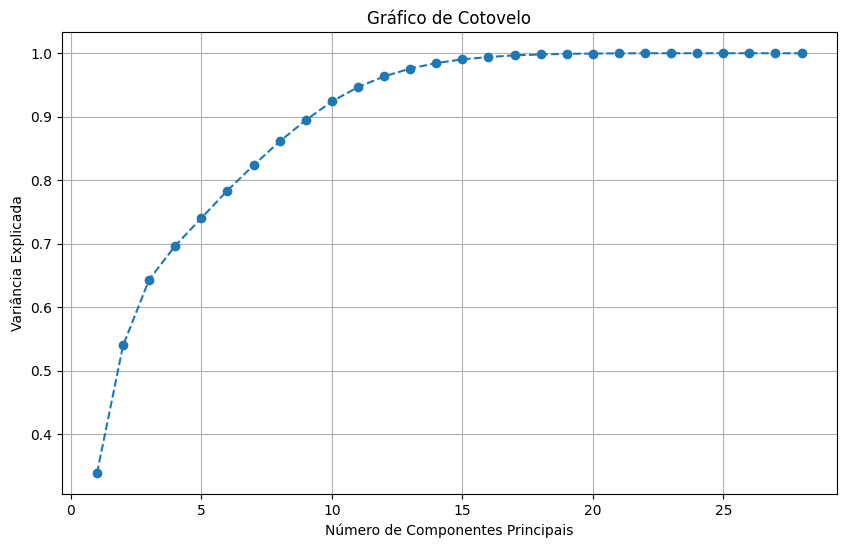

In [50]:
pca = PCA()
pca.fit(X) 
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Gráfico de Cotovelo')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada')
plt.grid(True)
plt.show()

In [51]:
n_components = .85
X_pca = PCA(n_components=n_components).fit_transform(X)
pd.DataFrame(X_pca)

,0,1,2,3,4,5,6,7
0,7.228819,6.104211,1.323818,-0.210887,0.129485,-0.048639,1.709203,-1.300774
1,7.231532,6.099946,1.325092,-0.210254,0.129584,-0.048612,1.711103,-1.303708
2,7.234903,6.094989,1.326536,-0.209511,0.129717,-0.048568,1.713451,-1.306851
3,7.230717,6.101836,1.324479,-0.210495,0.129558,-0.048610,1.710281,-1.302198
4,7.228976,6.105207,1.323445,-0.210913,0.129478,-0.048628,1.708474,-1.300035
...,...,...,...,...,...,...,...,...
5523,-5.114499,2.265894,-2.677384,0.505242,0.127477,-0.054135,-2.654952,0.902946
5524,-5.101446,2.271336,-2.675278,0.516634,0.122808,-0.056227,-2.740118,0.819411
5525,-5.122628,2.268770,-2.678923,0.501511,0.128459,-0.053709,-2.635405,0.925857
5526,-5.134644,2.273987,-2.684411,0.490743,0.132536,-0.051759,-2.565804,1.008059


In [62]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, stratify=y, test_size=0.20)

Acurácia: 0.49547920433996384
Precisão: 0.4685714285714286
Recall: 0.4685714285714286


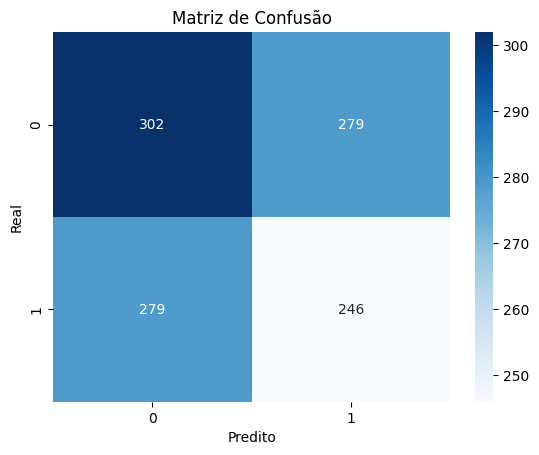

In [64]:
a = perform_predictions(X_train, X_test, y_train, y_test)

## Modelo DecisionTree

#### GridSearch

In [56]:
param_grid = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

grid_search = GridSearchCV(estimator=dtc, param_grid=param_grid, cv=5, scoring='accuracy')

# Realizar a busca nos dados de treino
grid_search.fit(X_train, y_train)

# Melhor modelo
best_model = grid_search.best_estimator_
print("Melhores parâmetros: ", grid_search.best_params_)

Melhores parâmetros:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10}


#### Cross validation

In [57]:
cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f'Scores de validação cruzada: {cv_scores}')
print(f'Média dos scores: {cv_scores.mean()}')

Scores de validação cruzada: [0.5        0.51717902 0.49457505 0.52036199 0.51855204]
Média dos scores: 0.510133619173083


## Ensemble Learning

In [59]:
rf = RandomForestClassifier(random_state=42)
gb = GradientBoostingClassifier(random_state=42)

rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print("RandomForest Acurácia: ", accuracy_score(y_test, y_pred_rf))

gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)
print("GradientBoosting Acurácia: ", accuracy_score(y_test, y_pred_gb))

RandomForest Acurácia:  0.5027124773960217
GradientBoosting Acurácia:  0.5072332730560579
